In [1]:
import sys
sys.path.insert(0, '../src/')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
import scipy.sparse as sp


from net.utils import *
from net import utils_netgan as utils
import net.net as net

## Synthetic graphs: kNN from a Gaussian

In [2]:
def get_cov(princ_comp, eigvals):
    # Find vector orthogonal to princ_comp
    if princ_comp[0] != 0:
        w = np.array([-princ_comp[1] / princ_comp[0], 1])
    else:
        w = np.array([1, 0])
    princ_comp = princ_comp / np.linalg.norm(princ_comp)
    w = w / np.linalg.norm(w)
    S = np.array([princ_comp, w]).T
    cov = (S @ np.diag([eigvals[0], eigvals[1]])) @ S.T
    return cov
        
def get_gaussian(n_samples, mean, cov):
    Xs = np.random.multivariate_normal(mean=mean, cov=cov, size=n_samples)
    return Xs

def plot_knn(Xs, k):
    A = kneighbors_graph(Xs, k, mode='connectivity').toarray()
    A = np.clip(A + A.T, a_min=None, a_max=1)
    A = np.tril(A)
    Is, Js = A.nonzero()
    nonzero_indices = np.array((Is, Js)).T
    
    f, axs = plt.subplots(figsize=(12,12))

    for l in range(nonzero_indices.shape[0]):
        axs.plot(Xs[nonzero_indices[l], 0], Xs[nonzero_indices[l], 1], 'ko-')
#     axs.scatter(Xs[:, 0], Xs[:, 1], s=10)

    axs.set_xlim(-10,10)
    axs.set_ylim(-10,10)

def plot_compare(Xs, train_graph, sampled_graph):
    f, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,12))
    plt.tight_layout()
    
    graphs = [[train_graph, sampled_graph], [train_graph * sampled_graph, (1 - train_graph) * sampled_graph]]
    titles = [['True kNN graph', 'Generated Graph'], ['Shared edges', 'New edges']]
    styles = [['ko-', 'ko-'], ['bo-', 'ro-']]
    for row in [0, 1]:
        for col in [0,1]:        
            A = graphs[row][col]
            A = np.tril(A)
            Is, Js = A.nonzero()
            nonzero_indices = np.array((Is, Js)).T
            for l in range(nonzero_indices.shape[0]):
                axs[row, col].plot(Xs[nonzero_indices[l], 0], Xs[nonzero_indices[l], 1], styles[row][col])
            axs[row, col].set_title(titles[row][col]) 

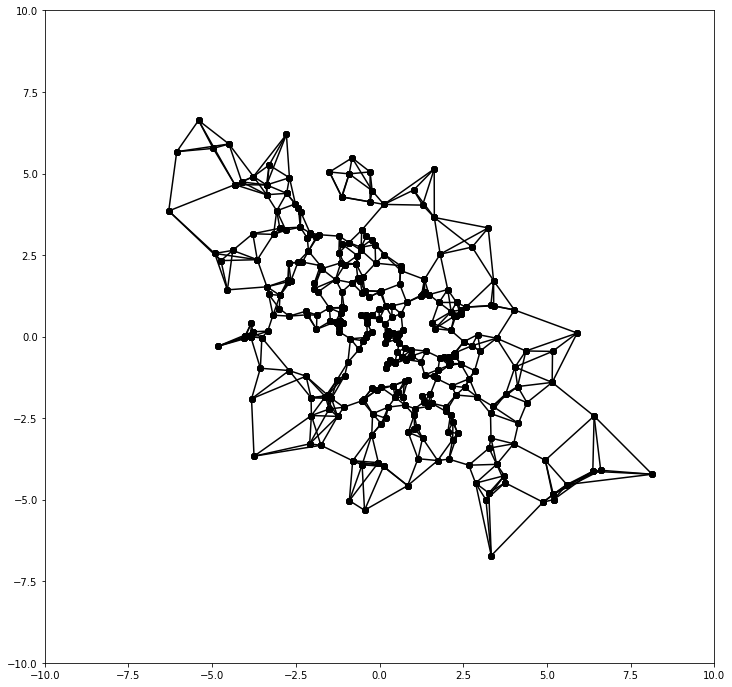

In [3]:
n = 300
mean = [0, 0]
cov = get_cov(princ_comp=[-1, 1], eigvals=[10, 3])
k = 4

Xs = get_gaussian(n_samples=n, mean=mean, cov=cov)

plot_knn(Xs, k=k)

#### Generate kNN graph 

In [4]:
n = 300
mean = [0, 0]
cov = get_cov(princ_comp=[-1, 1], eigvals=[10, 3])
k = 4

Xs = get_gaussian(n_samples=n, mean=mean, cov=cov)
A = kneighbors_graph(Xs, k, mode='connectivity').toarray()
A = np.clip(A + A.T, a_min=None, a_max=1)
A = sp.csr_matrix(A)

#### Split into train, test, and validation

In [5]:
val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(A, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Compute graph statistics

In [6]:
statistics_train = utils.compute_graph_statistics(train_graph.toarray())
statistics_train

{'d_max': 7.0,
 'd_min': 1.0,
 'd': 4.253333333333333,
 'LCC': 300,
 'wedge_count': 2255.0,
 'claw_count': 2163.0,
 'triangle_count': 300,
 'square_count': 32,
 'power_law_exp': 1.7079288143590705,
 'gini': 0.13196447230929986,
 'rel_edge_distr_entropy': 0.9941487717477132,
 'assortativity': -0.07400227287920583,
 'clustering_coefficient': 0.4160887656033287,
 'n_components': 1,
 'cpl': 12.383389074693422,
 'spectral_gap': 0.0016760066363851862}

#### Apply pipeline to generate a graph with our method

In [7]:
H = 4

W = train_graph.toarray()
W /= W.sum()

netmodel = net.NetWithoutSampling(W=W, 
                                  H=H, 
                                  loggers=[net.GraphStatisticsLoggerWithoutSampling(train_graph, val_ones,
                                                                                    val_zeros,
                                                                                    log_every=5),
                                           net.OverlapLoggerWithoutSampling(train_graph, print_every=50)])

netmodel.train(steps=400,
               optimizer_fn=torch.optim.Adam,
               optimizer_args={'lr': 0.01})

transition_matrix = netmodel()

scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                     symmetric=True)
scores_matrix = sp.csr_matrix(scores_matrix)

sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())

Step: 49, Loss: 4.96968, Edge-Overlap: 0.028
Step: 99, Loss: 3.80010, Edge-Overlap: 0.144
Step: 149, Loss: 3.22046, Edge-Overlap: 0.215
Step: 199, Loss: 2.83615, Edge-Overlap: 0.310
Step: 249, Loss: 2.58894, Edge-Overlap: 0.389
Step: 299, Loss: 2.42932, Edge-Overlap: 0.462
Step: 349, Loss: 2.32353, Edge-Overlap: 0.491
Step: 399, Loss: 2.24327, Edge-Overlap: 0.536


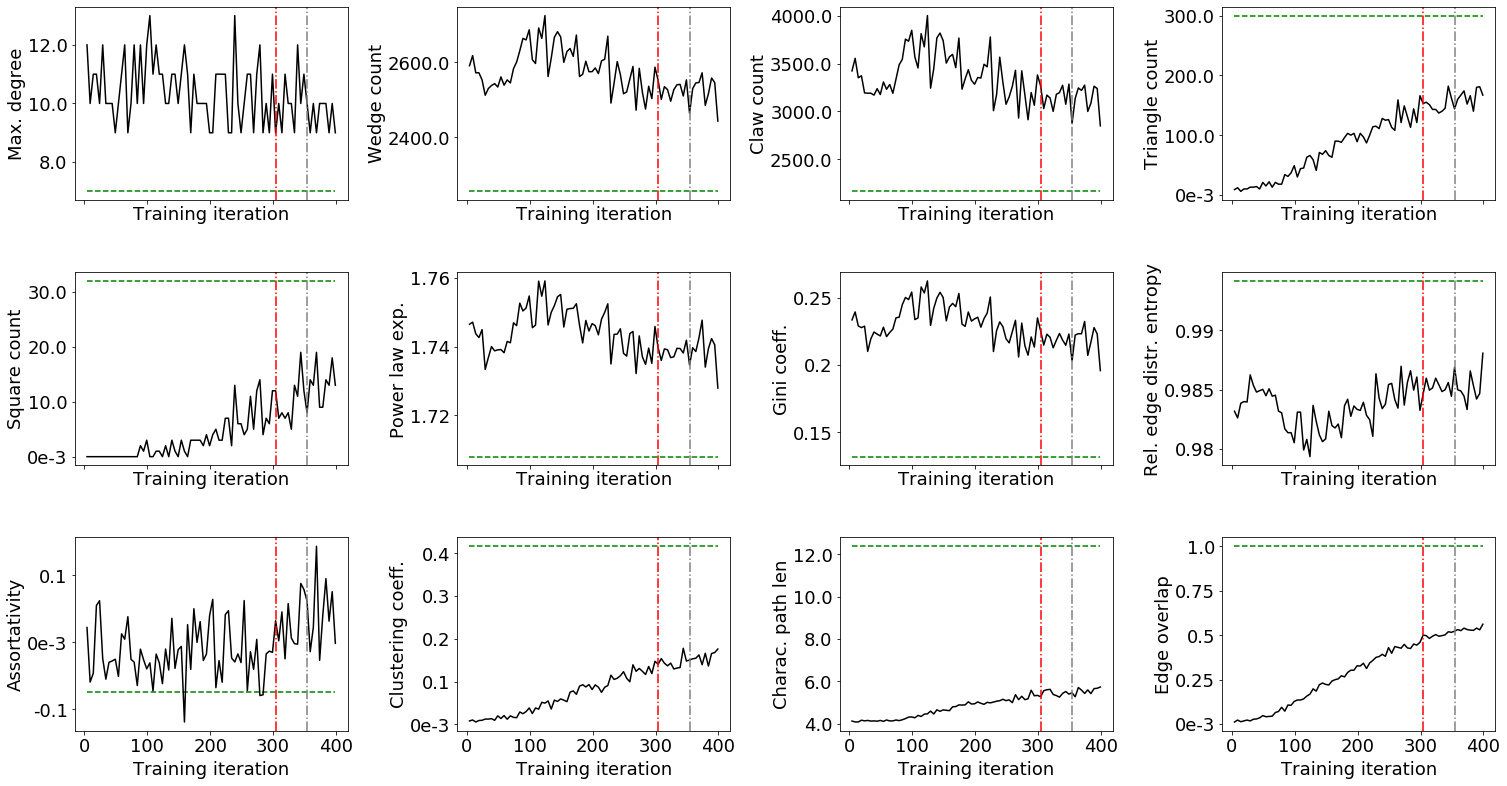

In [8]:
relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

# relevant_keys = ['d_max', 'assortativity', 'triangle_count', 'power_law_exp', 'LCC', 'overlap']

# relevant_keys = ['spectral_gap']

netmodel.loggers[0].print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)

#### Plot kNN graph vs learned graph to highlight new/shared edges

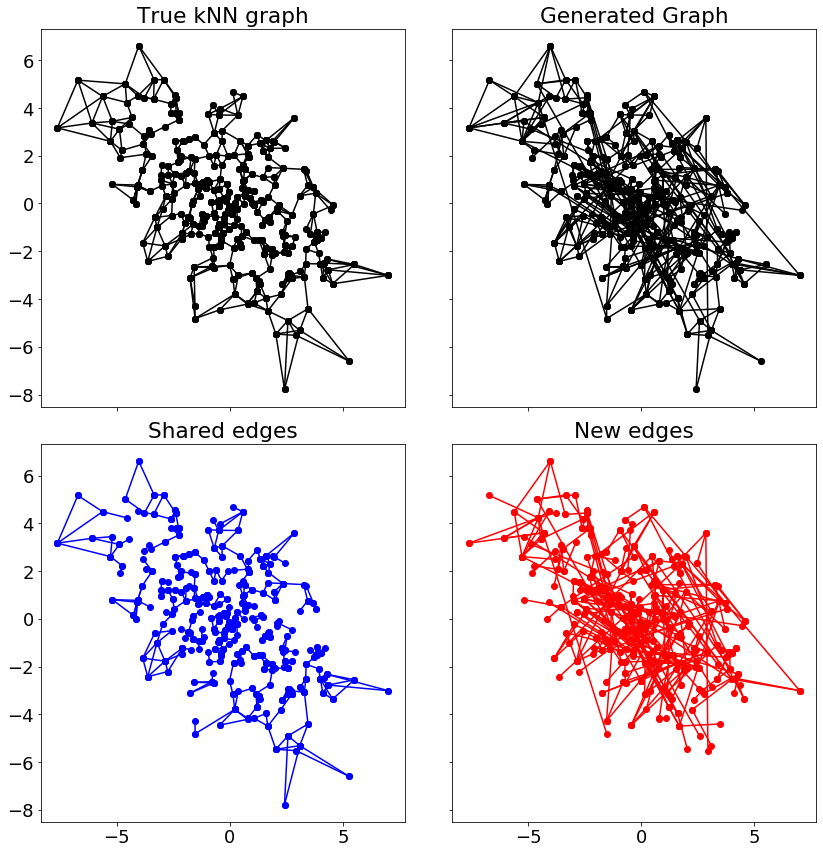

In [9]:
plot_compare(Xs=Xs, train_graph=train_graph.toarray(), sampled_graph=sampled_graph)

#### How long are the new generated edges compared to true edges?

In [10]:
def get_average_edgelength(Xs, A):
    A = np.tril(A)
    Is, Js = A.nonzero()
    nonzero_indices = np.array((Is, Js)).T
    avg_edgelength = 0
    num_edges = nonzero_indices.shape[0]
    for l in range(num_edges):
        avg_edgelength += np.linalg.norm(Xs[nonzero_indices[l][0]] - Xs[nonzero_indices[l][1]])
    return avg_edgelength / num_edges

In [11]:
true_average_edgelength = get_average_edgelength(Xs, train_graph.toarray())
generated_average_edgelength = get_average_edgelength(Xs, (1 - train_graph.toarray()) * sampled_graph)

In [12]:
print(f"Average length in true kNN graph={true_average_edgelength:.3f}, for new edges={generated_average_edgelength:.3f}.")

Average length in true kNN graph=0.553, for new edges=2.222.
